# Use the class


In [5]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
import os

from autoencoder3 import Autoencoder_composite

In [6]:


n_trash_qubit=3
n_qubit_autoencoder=4
n_qubit=n_qubit_autoencoder
dvc = qml.device('default.qubit', wires=n_qubit_autoencoder, shots=None)
import warnings
warnings.filterwarnings("ignore")

ae = Autoencoder_composite(n_qubit_autoencoder,n_trash_qubit,dvc,stages=['c11'])

ae.set_layers(3)
epochs= 15
n=100
opt=AdamOptimizer(stepsize=.2)
X=np.random.rand(n)*2*np.pi
np.random.shuffle(X)


the device has 4 qubits


1


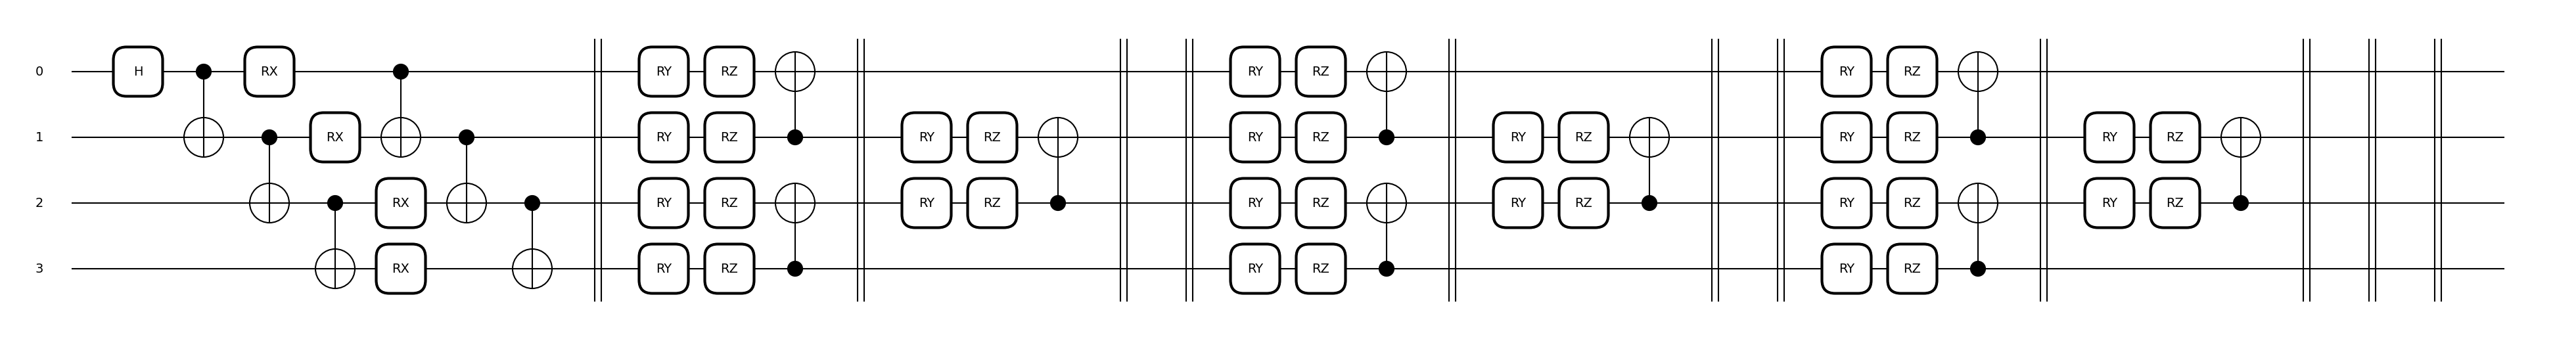

In [7]:
ae.plot_cirq()

In [8]:
_=ae.train(X,opt,[2],val_split=.5,batch_size=3)

Stage: 0, 	Epoch 2, 	Batch:16, 	Train Loss = 0.820980, 	Val Loss = 0.813427

--------------------------------------------------


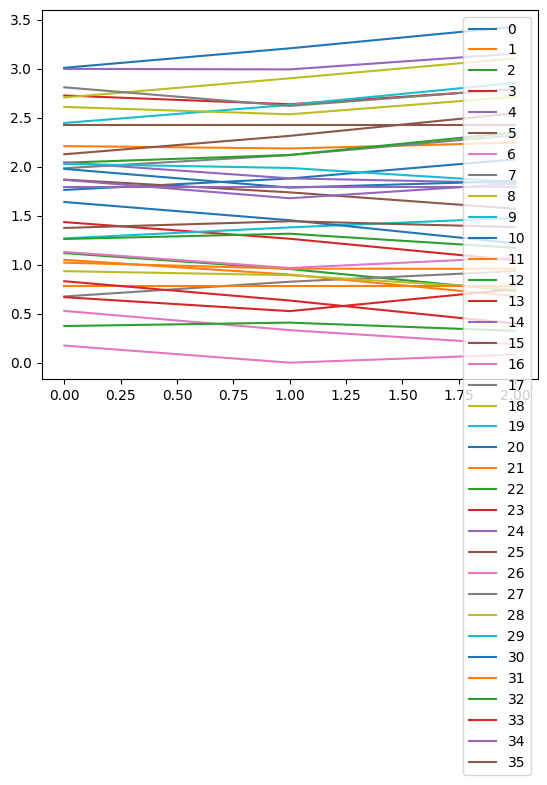

In [9]:
ae.plot_weights(
)

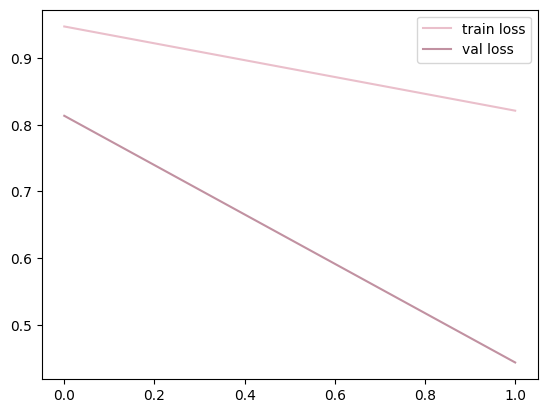

In [10]:
ae.plot_loss()

## Swap test for the dimentionality reduced state

## Swap test for the initial state

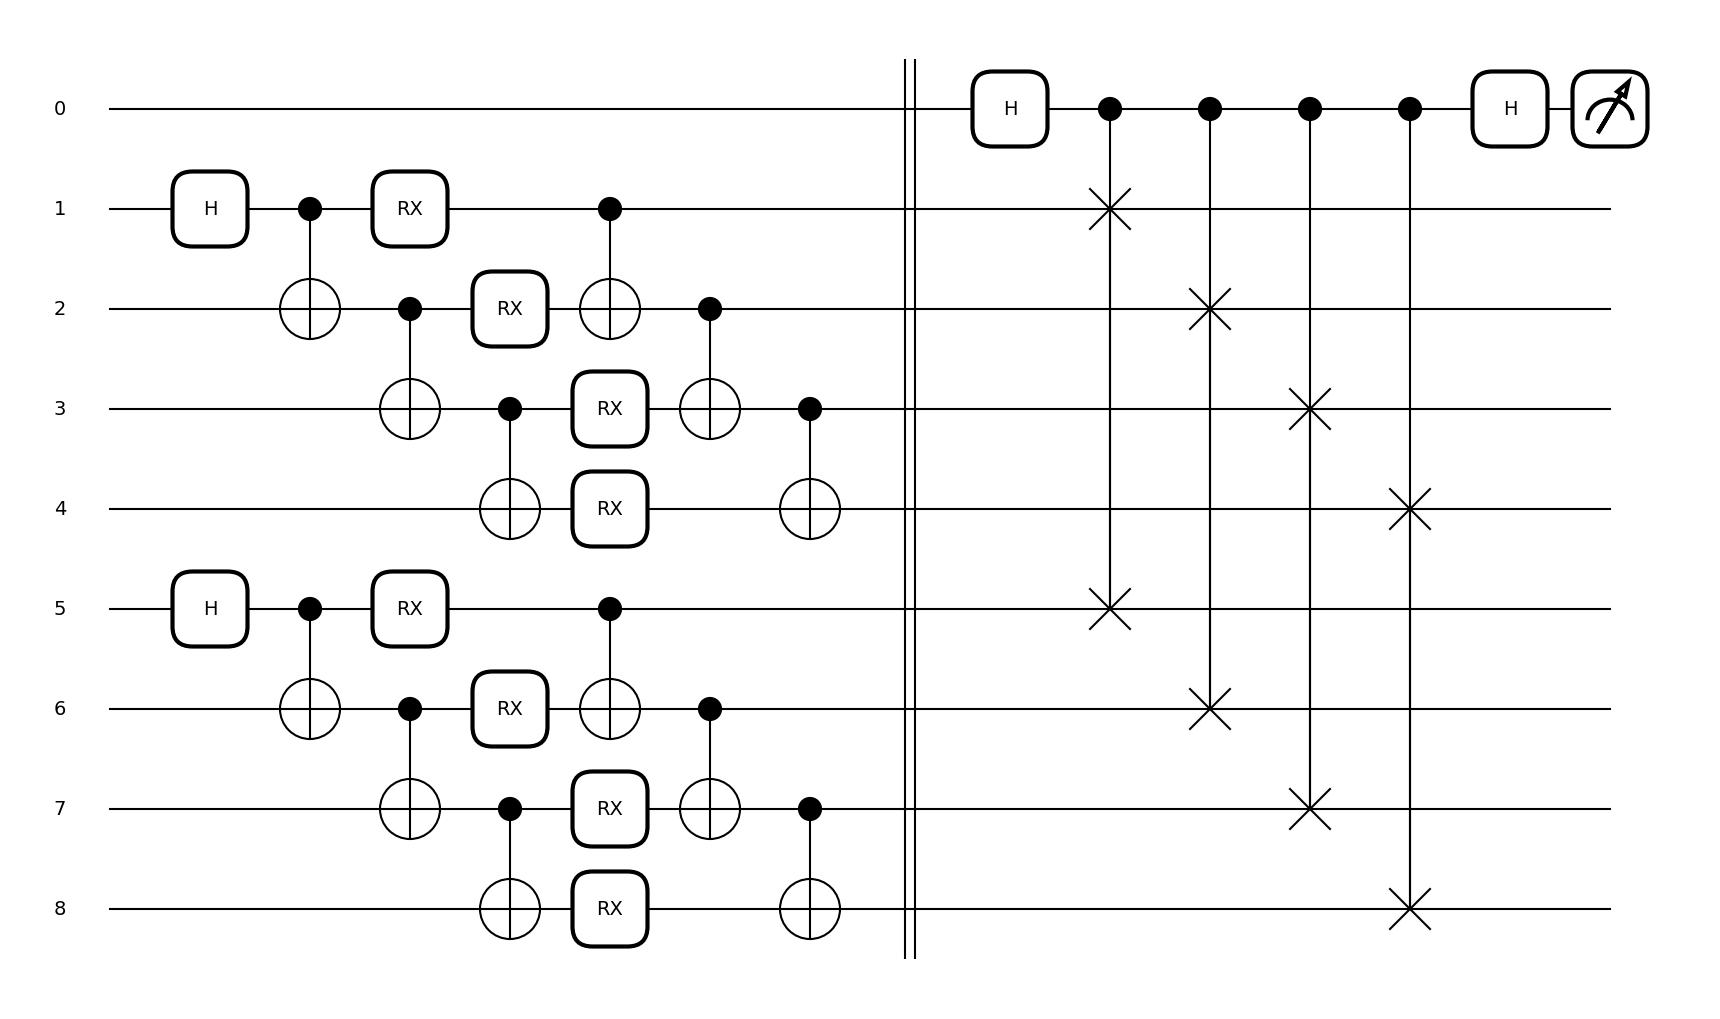

In [11]:
fig, ax = qml.draw_mpl(compare_state_orig(4))([3,6])
plt.show()


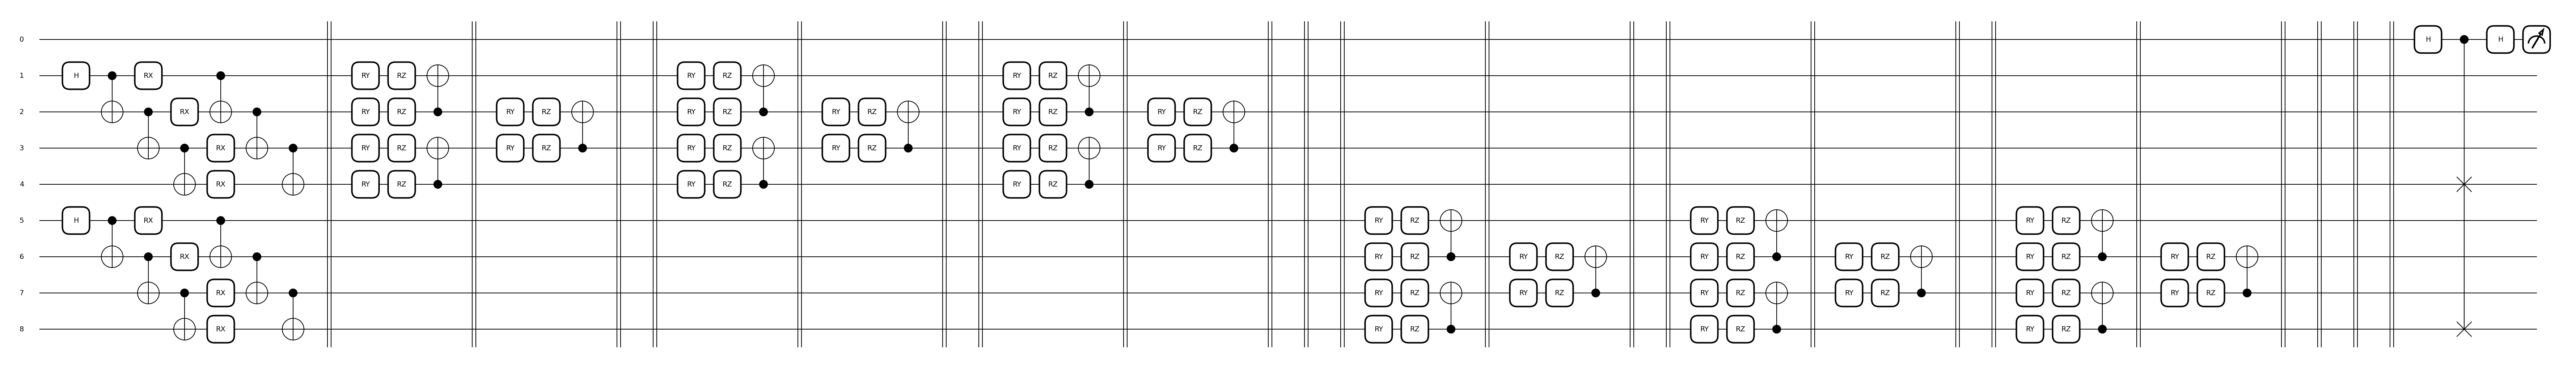

In [12]:
fig, ax = qml.draw_mpl(compare_state_ae(n_qubit_autoencoder,n_trash_qubit,ae))([3,6])
plt.show()


MSE of the error is 0.027391163390000004


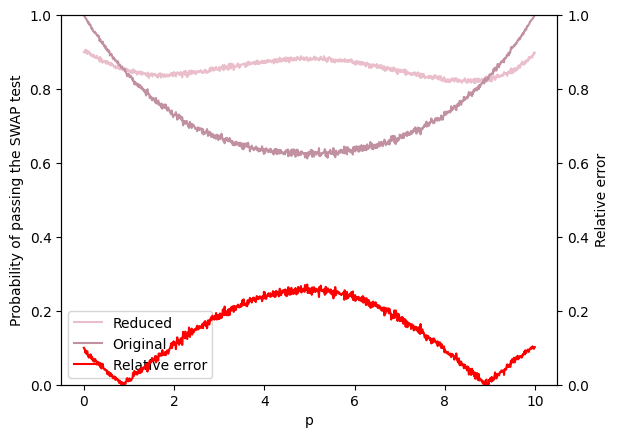

In [13]:
compare_fidelity(n_qubit_autoencoder,n_trash_qubit,ae)

In [8]:
import pandas as pd

df = pd.DataFrame(columns=['id','width','layers','npara','n2qgates','depth'])

In [9]:
w=list(range(2,9))
l=list(range(1,5))
idx=[]
width=[]
layers=[]
npara=[]
n2qgates=[]
depth=[]

j=0
for a in [6,11]:
    for b in w:
        for c in l:
            j-=-1
            if a == 6:
                npa=(b**2+3*b)*c
                n2q=(b**2-b)*c
                dep=(b**2-b+4)*c
            if a == 11:
                npa=(b*4-4)*c
                n2q=(b-1)*c
                dep=(6)*c
            idx.append(a)
            width.append(b)
            layers.append(c)
            npara.append(npa)
            n2qgates.append(n2q)
            depth.append(dep)

df = pd.DataFrame()
df['id']=idx
df['width']=width
df['layers']=layers
df['npara']=npara
df['n2qgates']=n2qgates
df['depth']=depth

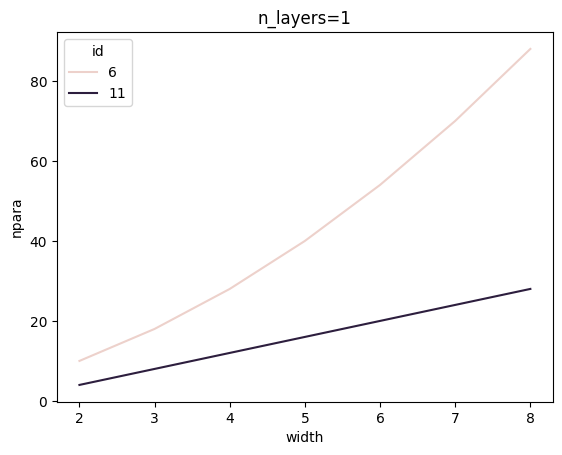

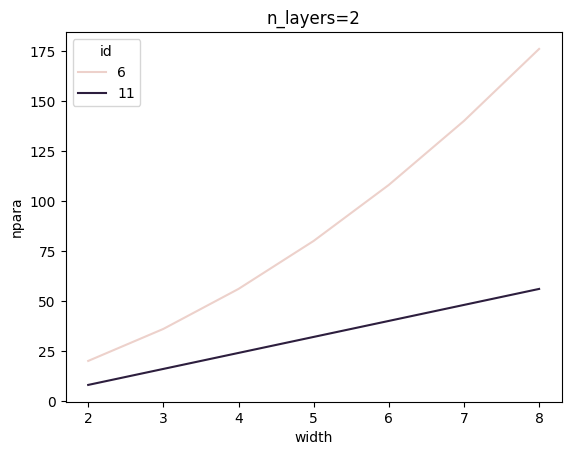

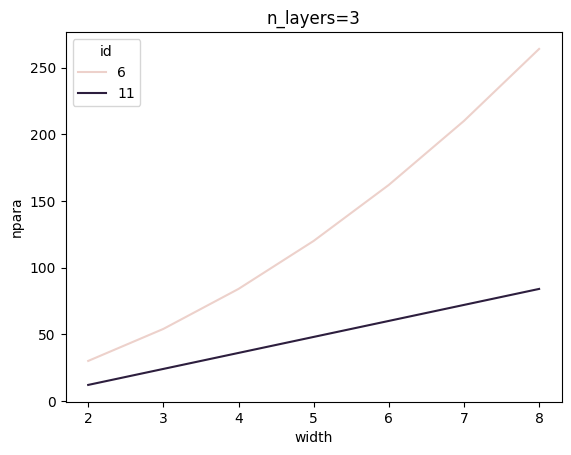

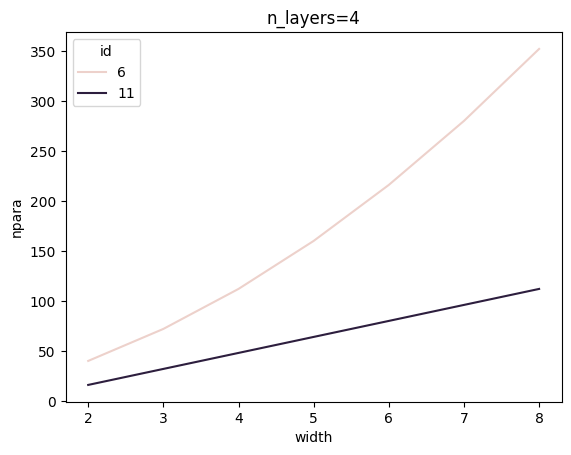

In [10]:
# for b in w:
#     sns.scatterplot( y=df[df.width==b ].npara,x=df[df.width==b ].layers,hue=df['id'])
#     plt.title(f'n_qubit={b}')
#     plt.show()
for b in l:
    sns.lineplot( y=df[df.layers==b ].npara,x=df[df.layers==b ].width,hue=df['id'])
    plt.title(f'n_layers={b}')
    plt.show()


In [26]:
a=[(a**2-a+4) for a in range(10)]
b=[18 for a in range(10)]

Text(0.5, 0, 'n_qubits')

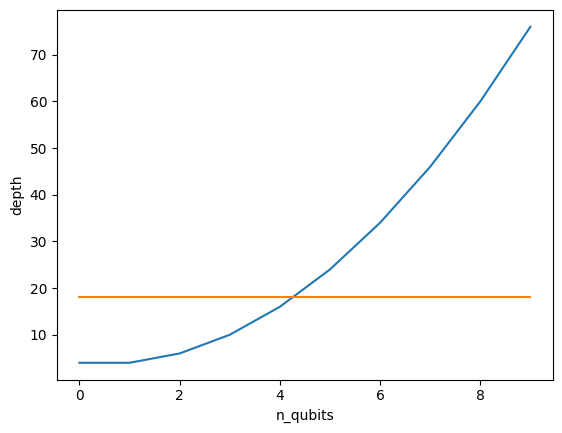

In [27]:
plt.plot(range(len(a)),a)
plt.plot(range(len(b)),b)
plt.ylabel('depth')
plt.xlabel('n_qubits')

Text(0.5, 0, 'n_qubits')

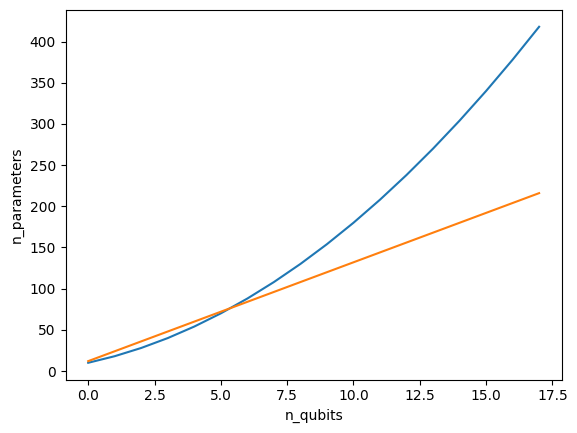

In [30]:
a=[(a**2+3*a) for a in range(2,20)]
b=[12*b-12 for b in range(2,20)]
plt.plot(range(len(a)),a)
plt.plot(range(len(b)),b)   
plt.ylabel('n_parameters')
plt.xlabel('n_qubits')